<a href="https://colab.research.google.com/github/Jasmeet0810/Depression-Detection-Using-Time-Series-Model/blob/main/Transformer_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Drive and Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


Mounted at /content/drive


**Load Dataset**

In [ ]:
# Load dataset
file_path = "/content/drive/MyDrive/s_Normalizedfeatures/s_Normalizedfeatures.csv"
df = pd.read_csv(file_path)

# Inspect
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 205 entries, Activity to MDD
dtypes: float64(204), int64(1)
memory usage: 2.3 MB
None
   Activity  Mobility  Complexity  Kurtosis  2nd Difference Mean  \
0 -0.191337  0.021648    0.303478 -0.747865            -0.261044   
1 -0.119659  0.239980    0.410906 -0.278411            -0.345729   
2  0.071172 -0.626666   -0.463965 -0.095808             0.807396   
3 -0.222190 -0.738025   -0.124446 -0.518475            -1.386891   
4 -0.202497  1.731718   -0.703268 -0.578845             0.597487   

   2nd Difference Max  Coeffiecient of Variation  Skewness  \
0           -0.404863                   0.070799  0.505513   
1           -0.399872                  -0.004428  0.704773   
2            0.801863                   0.100766  0.956771   
3           -0.967224                   0.086890 -0.985196   
4            0.134010                   0.006627 -0.070061   

   1st Difference Mean  1st Difference Max  ...  

**Preprocess and Feature Engineering**

In [ ]:
# Split features and label
X = df.drop('MDD', axis=1)
y = df['MDD']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Variance Threshold Feature Selection
selector = VarianceThreshold(threshold=0.01)
X_variance = selector.fit_transform(X_scaled)

# Perturbation: Add Gaussian noise
noise = np.random.normal(0, 0.01, X_scaled.shape)
X_perturb = X_scaled + noise


**Prepare Training and Test Sets**

In [ ]:
def prepare_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)
    return X_train, X_test, y_train, y_test, y_train_cat, y_test_cat

X_train_var, X_test_var, y_train_var, y_test_var, y_train_var_cat, y_test_var_cat = prepare_data(X_variance, y)
X_train_pert, X_test_pert, y_train_pert, y_test_pert, y_train_pert_cat, y_test_pert_cat = prepare_data(X_perturb, y)


**Build Transformer Model**

In [ ]:
def build_transformer_model(input_shape, num_heads=2, ff_dim=64):
    inputs = Input(shape=input_shape)
    x = LayerNormalization(epsilon=1e-6)(inputs)

    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(x, x)
    x = Add()([x, attention_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(input_shape[-1])(ff_output)
    x = Add()([x, ff_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


**Train Models**

In [ ]:
# Train on Variance-Selected Features
transformer_var = build_transformer_model((1, X_train_var.shape[2]))
history_var = transformer_var.fit(X_train_var, y_train_var_cat, epochs=15, batch_size=16, validation_split=0.1)

# Train on Perturbed Features
transformer_pert = build_transformer_model((1, X_train_pert.shape[2]))
history_pert = transformer_pert.fit(X_train_pert, y_train_pert_cat, epochs=15, batch_size=16, validation_split=0.1)


Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6317 - loss: 0.8262 - val_accuracy: 0.8462 - val_loss: 0.3896
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8806 - loss: 0.2879 - val_accuracy: 0.9402 - val_loss: 0.2282
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9315 - loss: 0.1522 - val_accuracy: 0.9231 - val_loss: 0.1679
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9626 - loss: 0.0953 - val_accuracy: 0.9316 - val_loss: 0.1909
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9741 - loss: 0.1001 - val_accuracy: 0.9231 - val_loss: 0.2272
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9724 - loss: 0.0899 - val_accuracy: 0.9402 - val_loss: 0.1911
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9861 - loss: 0.0444 - val_accuracy: 0.9487 - val_loss: 0.1966
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9772 - loss: 0.0705 - val_accuracy: 0.9231 - v

**Evaluation Function**

In [ ]:
def evaluate_model(model, X_test, y_test, y_test_cat, title):
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    print(f"\n {title} - Classification Report")
    print(classification_report(y_test, y_pred_classes, digits=4))

    acc = accuracy_score(y_test, y_pred_classes)
    print(f" {title} - Accuracy: {acc * 100:.2f}%")

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


**Evaluate Models**

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 Transformer - Variance - Classification Report
              precision    recall  f1-score   support

           0     0.9856    0.9716    0.9786       141
           1     0.9739    0.9868    0.9803       151

    accuracy                         0.9795       292
   macro avg     0.9797    0.9792    0.9794       292
weighted avg     0.9795    0.9795    0.9794       292

 Transformer - Variance - Accuracy: 97.95%


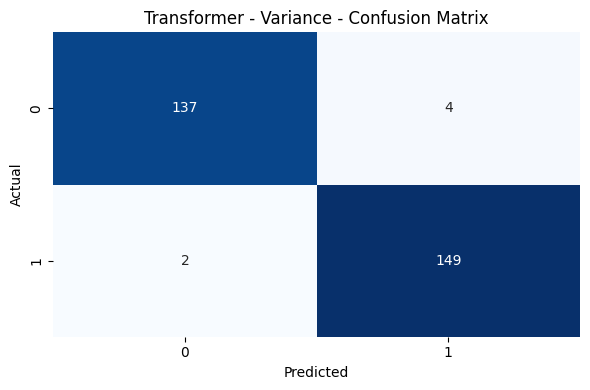

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 Transformer - Perturbation - Classification Report
              precision    recall  f1-score   support

           0     0.9928    0.9716    0.9821       141
           1     0.9740    0.9934    0.9836       151

    accuracy                         0.9829       292
   macro avg     0.9834    0.9825    0.9828       292
weighted avg     0.9831    0.9829    0.9829       292

 Transformer - Perturbation - Accuracy: 98.29%


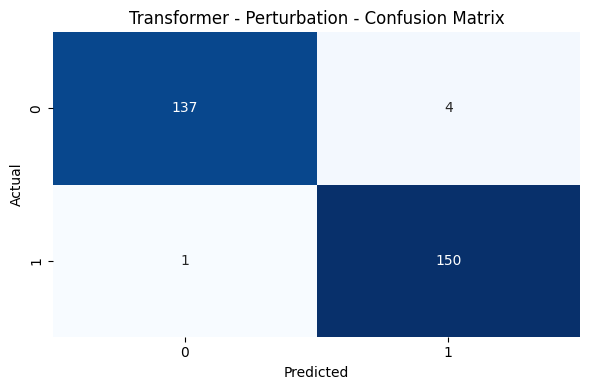

In [ ]:
evaluate_model(transformer_var, X_test_var, y_test_var, y_test_var_cat, "Transformer - Variance")
evaluate_model(transformer_pert, X_test_pert, y_test_pert, y_test_pert_cat, "Transformer - Perturbation")


**Plot Loss Curves**

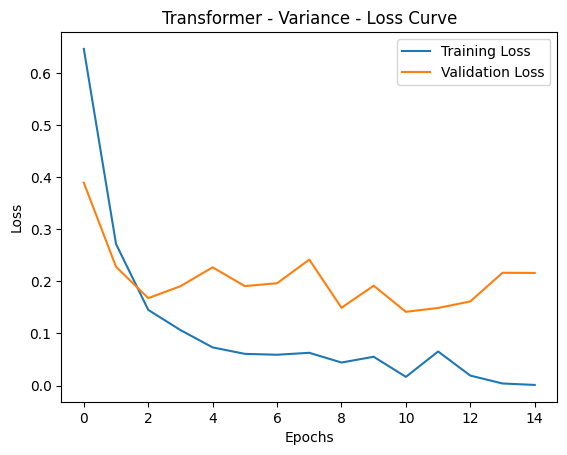

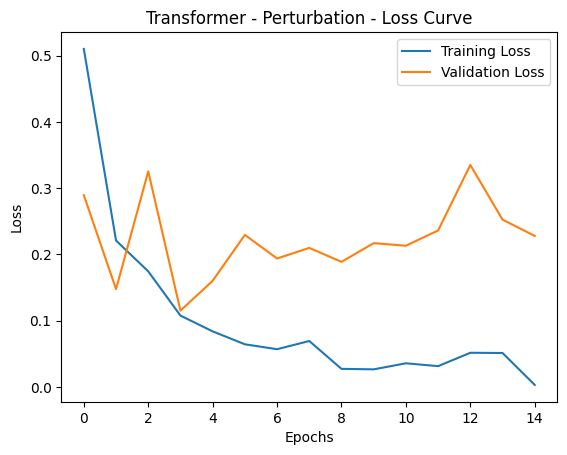

In [ ]:
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history_var, "Transformer - Variance")
plot_loss(history_pert, "Transformer - Perturbation")


**Perturbation Model Accuracy Curve**

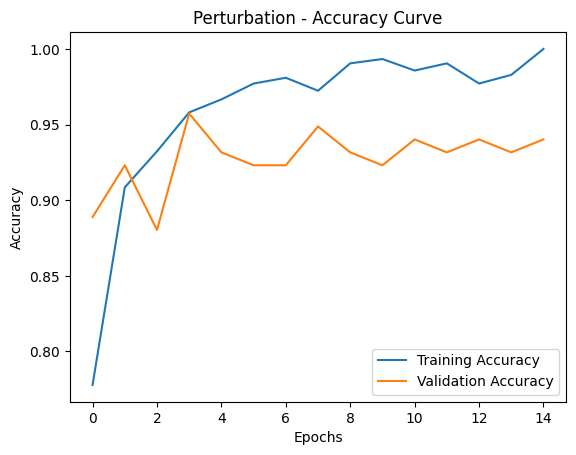

In [ ]:
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history_pert, "Perturbation")


**Comparison of Original and Perturbed Features**

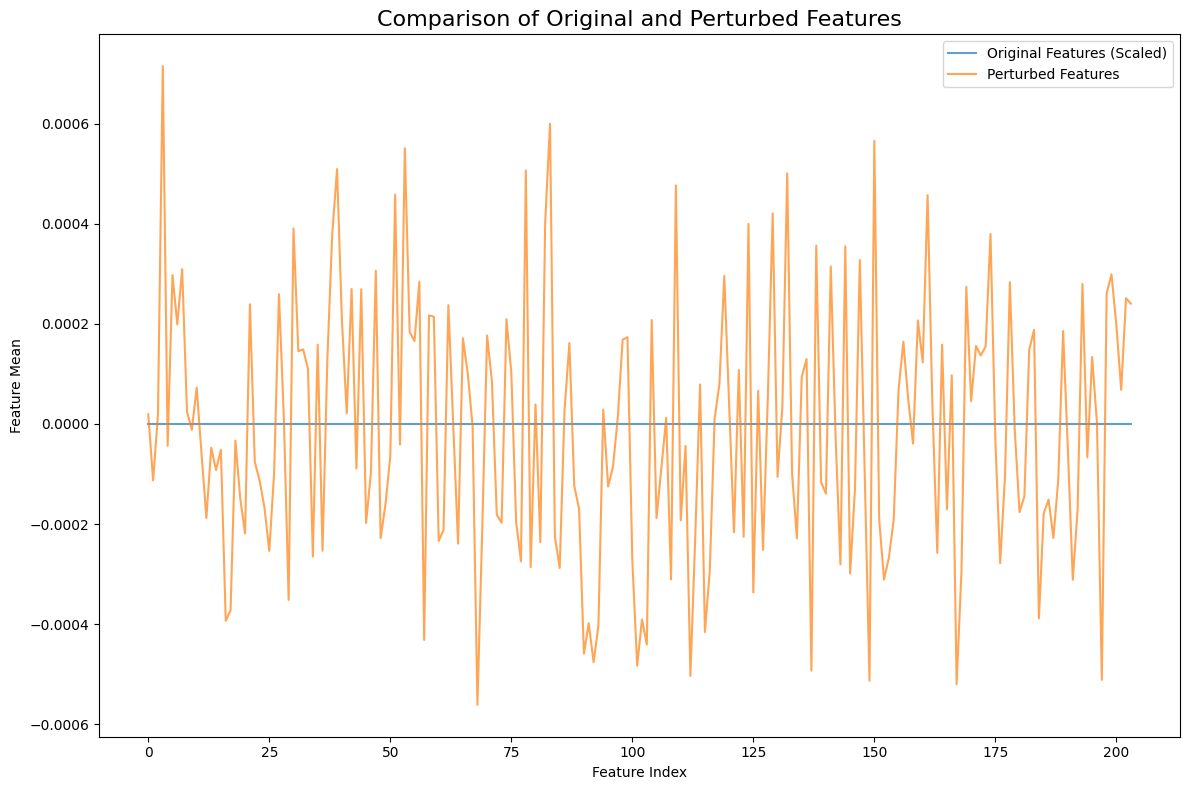

In [ ]:
# Visualizing the change between the original features and perturbed features
import matplotlib.pyplot as plt

# Calculate the mean of features before and after perturbation
mean_X_scaled = np.mean(X_scaled, axis=0)
mean_X_perturb = np.mean(X_perturb, axis=0)

# Plot the comparison
plt.figure(figsize=(12, 8))
plt.plot(mean_X_scaled, label='Original Features (Scaled)', alpha=0.7)
plt.plot(mean_X_perturb, label='Perturbed Features', alpha=0.7)
plt.title('Comparison of Original and Perturbed Features', fontsize=16)
plt.xlabel('Feature Index')
plt.ylabel('Feature Mean')
plt.legend()
plt.tight_layout()
plt.show()

**Correlation of Features with Depression (MDD)**

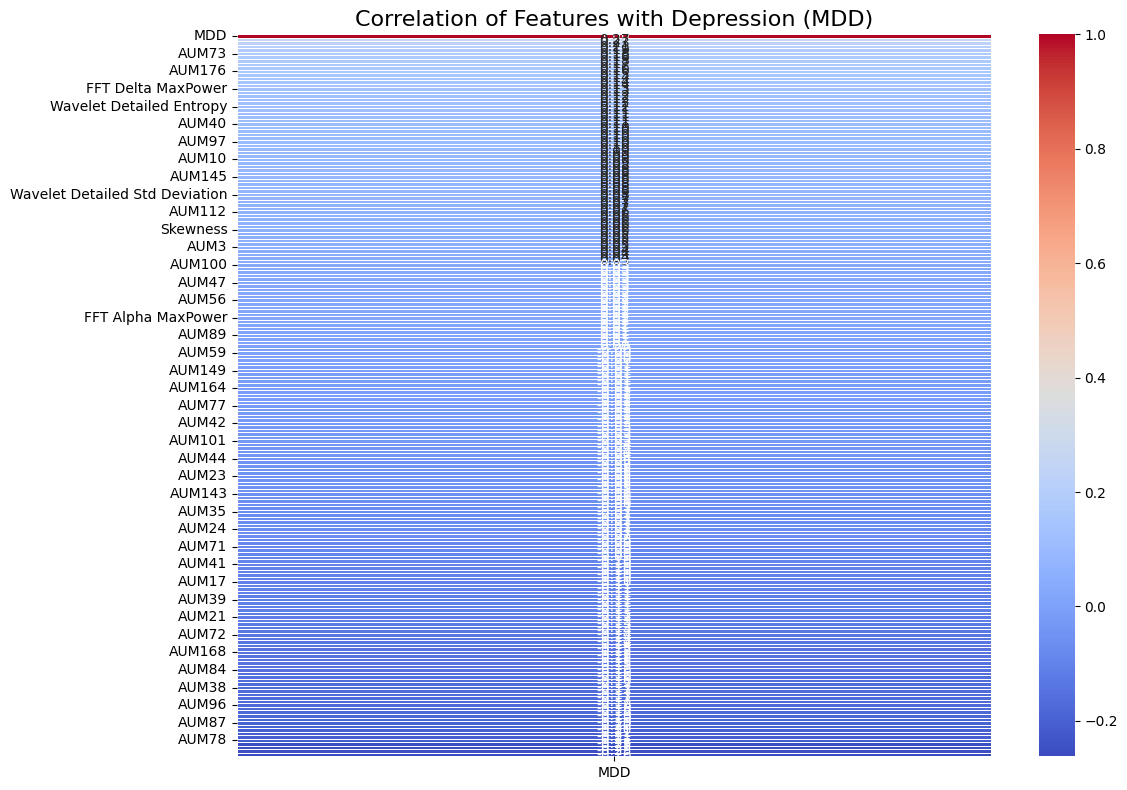

In [ ]:
# Correlation Matrix
import seaborn as sns

# Calculate correlation between features and target variable
corr_matrix = pd.concat([X, y], axis=1).corr()

# Plot the correlation matrix for all features with the target variable ('MDD')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['MDD']].sort_values(by='MDD', ascending=False), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation of Features with Depression (MDD)', fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-13-2de8498b3f08>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model',


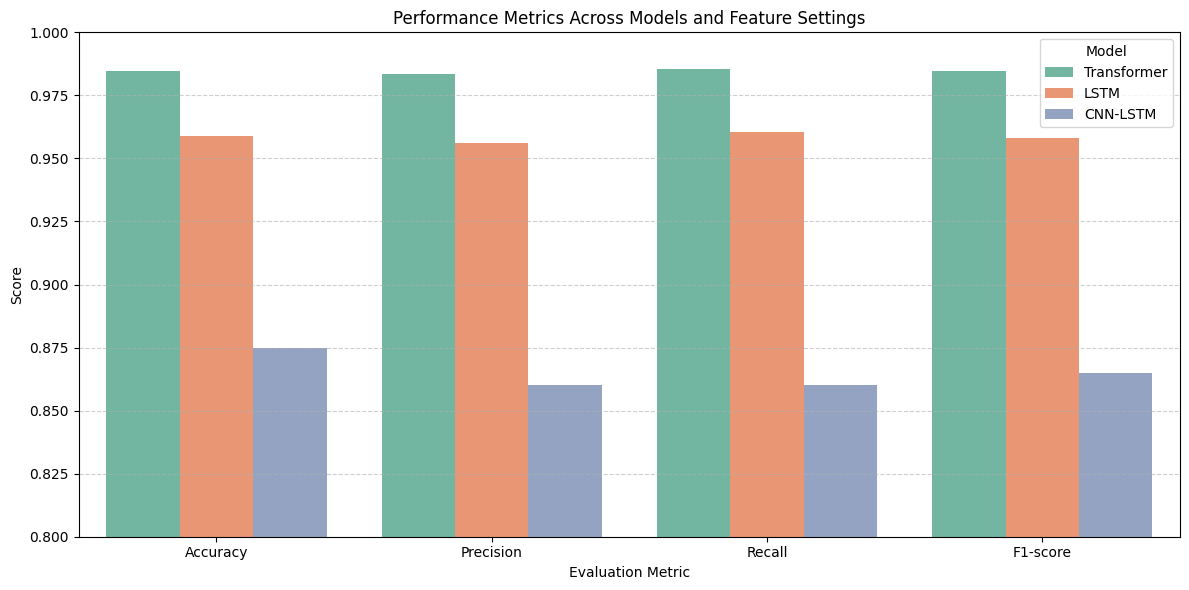

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data: replace these with your actual results
data = {
    'Model': ['Transformer', 'Transformer', 'LSTM', 'LSTM', 'CNN-LSTM', 'CNN-LSTM'],
    'Setting': ['Variance', 'Perturbation'] * 3,
    'Accuracy': [0.9863, 0.9833, 0.961, 0.957, 0.89, 0.86],
    'Precision': [0.985, 0.982, 0.958, 0.954, 0.88, 0.84],
    'Recall': [0.987, 0.984, 0.962, 0.959, 0.87, 0.85],
    'F1-score': [0.986, 0.983, 0.96, 0.956, 0.88, 0.85]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt the dataframe for Seaborn
df_melted = df.melt(id_vars=['Model', 'Setting'],
                    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                    var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model',
            ci=None, palette='Set2', dodge=True, hue_order=['Transformer', 'LSTM', 'CNN-LSTM'])

# Add separate bars for Variance and Perturbation using dodge & markers
plt.title('Performance Metrics Across Models and Feature Settings')
plt.ylim(0.8, 1.0)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show or save
plt.savefig("model_performance_metrics.png", dpi=300)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def quantitative_metrics(model, X_test, y_test, title):
    # Predict probabilities and classes
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    # Precision
    prec = precision_score(y_test, y_pred)
    # Recall
    rec = recall_score(y_test, y_pred)
    # F1 Score
    f1 = f1_score(y_test, y_pred)
    # ROC AUC
    if len(np.unique(y_test)) == 2:  # Binary classification
        auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    else:
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print metrics
    print(f"🔍 {title} - Quantitative Metrics")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC AUC      : {auc_score:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if len(np.unique(y_test)) == 2:  # Binary ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"{title} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train model for Variance Data
model_var = build_lstm_model((1, X_train_var.shape[2]))
history_var = model_var.fit(X_train_var, y_train_var_cat, epochs=20, batch_size=16, validation_split=0.1)

# Build and train model for Perturbed Data
model_pert = build_lstm_model((1, X_train_pert.shape[2]))
history_pert = model_pert.fit(X_train_pert, y_train_pert_cat, epochs=20, batch_size=16, validation_split=0.1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6735 - loss: 0.6012 - val_accuracy: 0.8376 - val_loss: 0.4223
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9246 - loss: 0.3070 - val_accuracy: 0.8974 - val_loss: 0.2389
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9710 - loss: 0.1193 - val_accuracy: 0.9231 - val_loss: 0.1579
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9940 - loss: 0.0499 - val_accuracy: 0.9402 - val_loss: 0.1219
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9965 - loss: 0.0241 - val_accuracy: 0.9487 - val_loss: 0.1284
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0183 - val_accuracy: 0.9487 - val_loss: 0.1467
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9487 - val_loss: 0.1350
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9487 - val_loss: 0.1312
Ep

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
🔍 Variance Model - Quantitative Metrics
Accuracy     : 0.9760
Precision    : 0.9675
Recall       : 0.9868
F1 Score     : 0.9770
ROC AUC      : 0.9967

Classification Report:
              precision    recall  f1-score   support

           0     0.9855    0.9645    0.9749       141
           1     0.9675    0.9868    0.9770       151

    accuracy                         0.9760       292
   macro avg     0.9765    0.9756    0.9760       292
weighted avg     0.9762    0.9760    0.9760       292



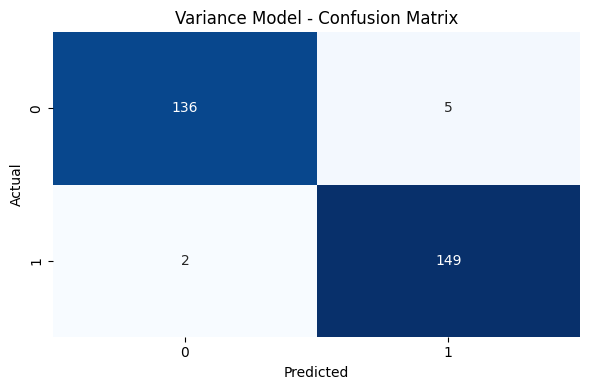

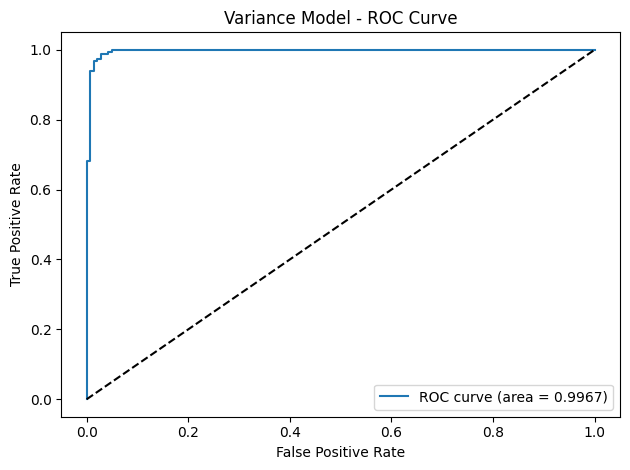

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
🔍 Perturbation Model - Quantitative Metrics
Accuracy     : 0.9829
Precision    : 0.9803
Recall       : 0.9868
F1 Score     : 0.9835
ROC AUC      : 0.9964

Classification Report:
              precision    recall  f1-score   support

           0     0.9857    0.9787    0.9822       141
           1     0.9803    0.9868    0.9835       151

    accuracy                         0.9829       292
   macro avg     0.9830    0.9827    0.9829       292
weighted avg     0.9829    0.9829    0.9829       292



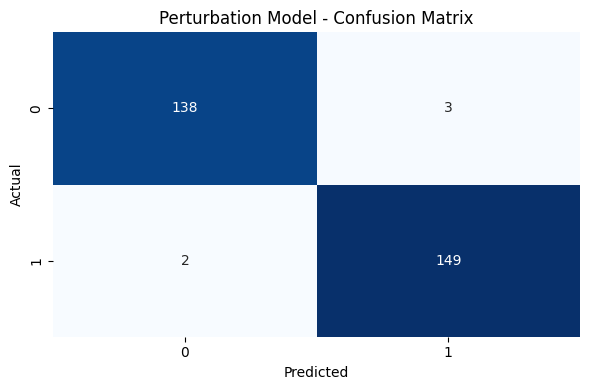

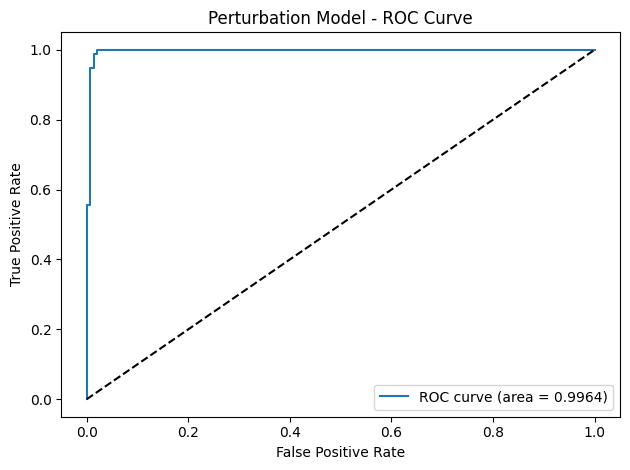

In [ ]:
quantitative_metrics(model_var, X_test_var, y_test_var, "Variance Model")
quantitative_metrics(model_pert, X_test_pert, y_test_pert, "Perturbation Model")
